In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('drive/My Drive/Sunspots1.csv')
df


,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8


In [ ]:
df = df.drop("Unnamed: 0", axis=1)
df

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3260,2020-09-30,0.6
3261,2020-10-31,14.4
3262,2020-11-30,34.0
3263,2020-12-31,21.8


In [ ]:
df = df.rename(columns={"Date":"date","Monthly Mean Total Sunspot Number":"ssn"})
df

,date,ssn
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3260,2020-09-30,0.6
3261,2020-10-31,14.4
3262,2020-11-30,34.0
3263,2020-12-31,21.8


In [ ]:
df.date = pd.to_datetime(df.date)

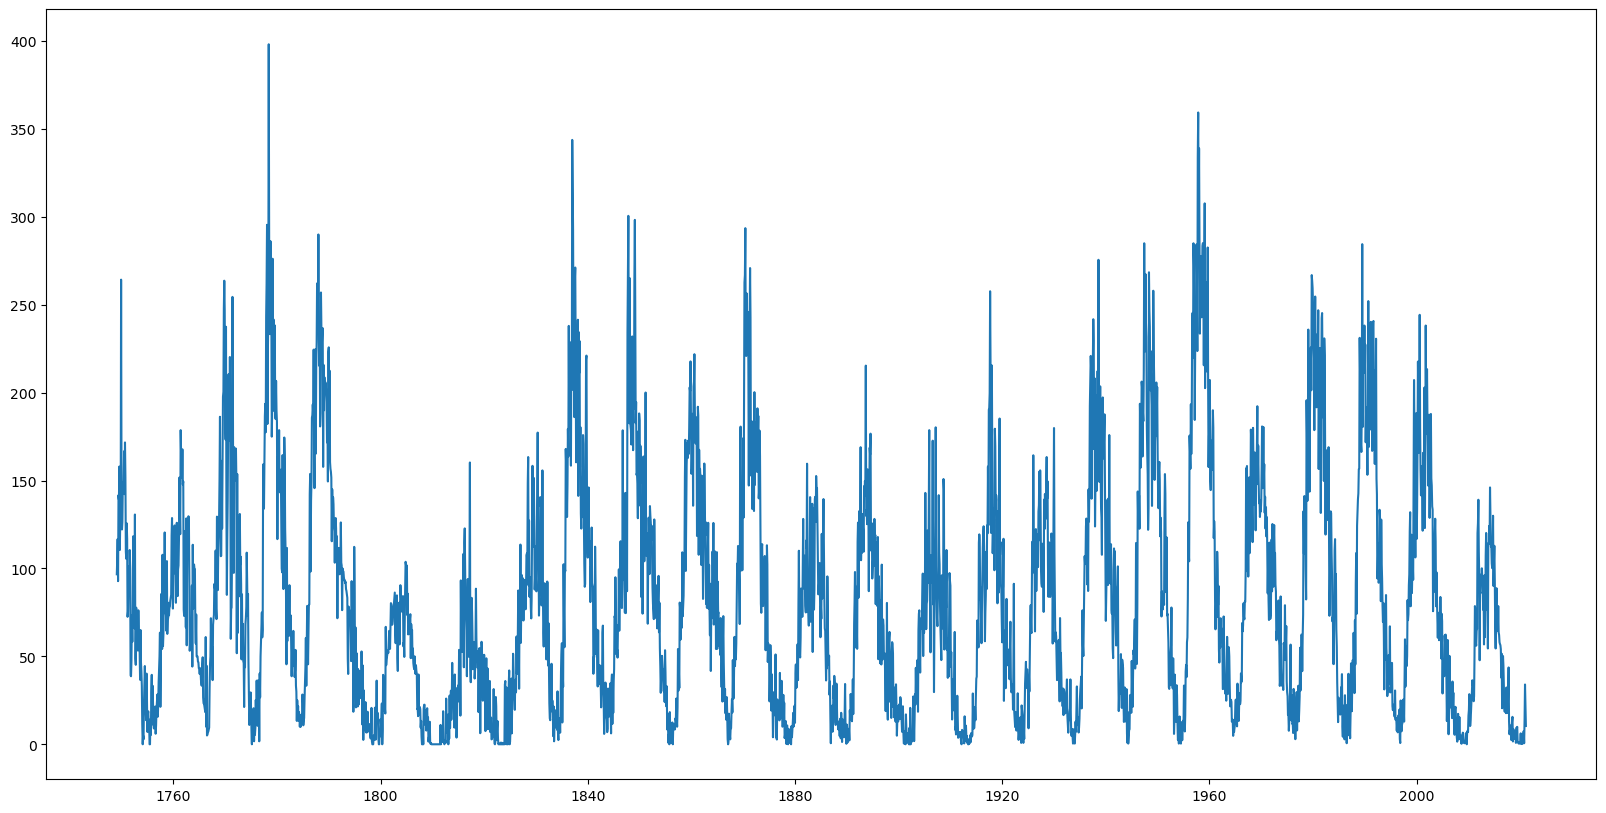

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df.date, df.ssn)

In [ ]:
df.set_index(df.date, inplace=True)

In [ ]:
df



,date,ssn
date,,
1749-01-31,1749-01-31,96.7
1749-02-28,1749-02-28,104.3
1749-03-31,1749-03-31,116.7
1749-04-30,1749-04-30,92.8
1749-05-31,1749-05-31,141.7
...,...,...
2020-09-30,2020-09-30,0.6
2020-10-31,2020-10-31,14.4
2020-11-30,2020-11-30,34.0


In [ ]:
df.drop(columns="date", inplace=True)
df

,ssn
date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0


In [ ]:
scaler = MinMaxScaler()
scaler.fit(df[["ssn"]])

MinMaxScaler()

In [ ]:
y = scaler.transform(df[["ssn"]])

In [ ]:
df["y"] = y

In [ ]:
df

,ssn,y
date,,
1749-01-31,96.7,0.242843
1749-02-28,104.3,0.261929
1749-03-31,116.7,0.293069
1749-04-30,92.8,0.233049
1749-05-31,141.7,0.355851
...,...,...
2020-09-30,0.6,0.001507
2020-10-31,14.4,0.036163
2020-11-30,34.0,0.085384


In [ ]:
size = int(len(y) * 0.9)

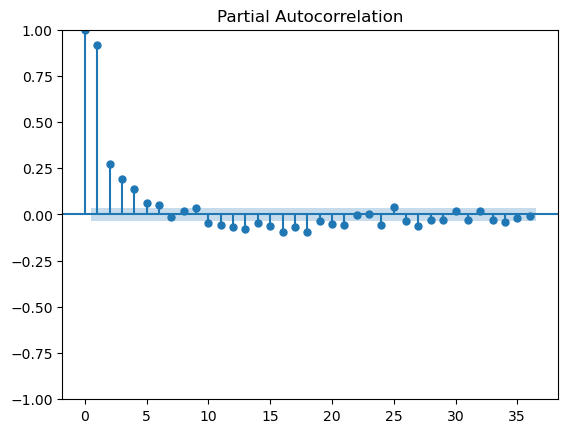

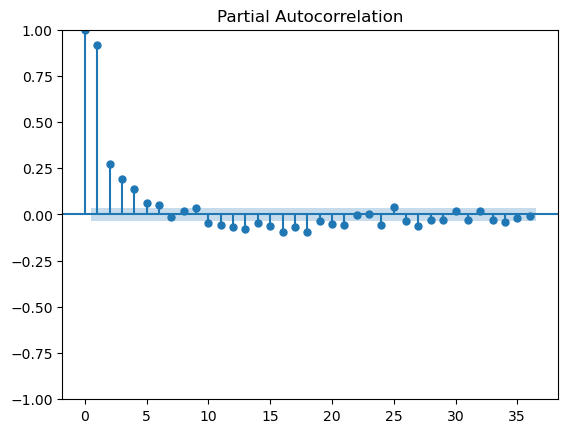

In [ ]:
plot_pacf(df.y)

In [ ]:
def shift(lags):

    df_new = df.copy()

    for i in range(1,lags+1):
        df_new[f"y{i}"] = df_new["y"].shift(i)

    df_new.dropna(inplace=True)

    X_train = df_new[:size][[f"y{i}" for i in range(1,lags+1)]]

    y_train = df_new[:size]["y"]

    return np.array(X_train), np.array(y_train)

In [ ]:
def shift_test(lags):
    df_new = df.copy()

    for i in range(1,lags+1):
        df_new[f"y{i}"] = df_new["y"].shift(i)

    df_new.dropna(inplace=True)

    X_train = df_new[size:][[f"y{i}" for i in range(1,lags+1)]]

    y_train = df_new[size:]["y"]

    return np.array(X_train), np.array(y_train)

In [ ]:
X_train, y_train = shift(16)

X_test, y_test = shift_test(16)


X_train, X_test = X_train.reshape(X_train.shape[0], 16, 1), X_test.reshape(X_test.shape[0], 16, 1)

In [ ]:
y_test

array([1.16273230e-01, 5.42440984e-02, 4.87192366e-02, 5.65042692e-02,
       5.12305374e-02, 4.57056755e-02, 3.94274234e-02, 7.68458061e-02,
       3.51582120e-02, 3.74183827e-02, 3.34003014e-02, 1.93370166e-02,
       3.16423908e-02, 1.70768458e-02, 1.90858865e-02, 4.14364641e-02,
       2.96333501e-02, 4.94726268e-02, 7.53390256e-03, 1.75791060e-03,
       6.25313913e-02, 3.51582120e-02, 1.85836263e-02, 2.76243094e-02,
       3.03867403e-02, 5.77599196e-02, 6.37870417e-02, 5.22350578e-02,
       3.23957810e-02, 8.96534405e-02, 1.49924661e-01, 8.23706680e-02,
       1.26569563e-01, 1.39377197e-01, 1.11752888e-01, 1.26067303e-01,
       2.05926670e-01, 1.77297840e-01, 1.85836263e-01, 2.27272727e-01,
       2.42842793e-01, 3.04118533e-01, 3.31491713e-01, 1.97137117e-01,
       2.44349573e-01, 2.99347062e-01, 2.15971873e-01, 2.46107484e-01,
       2.59919638e-01, 2.35057760e-01, 3.75690608e-01, 5.20341537e-01,
       4.35710698e-01, 3.57358112e-01, 2.66951281e-01, 4.23656454e-01,
      

In [ ]:
baseline_prediction = np.mean(y_train)

y_baseline_pred = np.full_like(y_test, baseline_prediction)

baseline_mae = mean_absolute_error(y_test, y_baseline_pred)

baseline_mae = np.array(baseline_mae).reshape(1, -1)

baseline_mae = scaler.inverse_transform(baseline_mae)

print("Baseline MAE:", baseline_mae[0][0])

Baseline MAE: 53.3939550277


In [ ]:
# dict_results = {"Lags": [], "MAE": []}

# for i in range(11, 19):
#     X_train, y_train = shift(i)

#     X_test, y_test = shift_test(i)

#     X_train, X_test = X_train.reshape(X_train.shape[0], i, 1), X_test.reshape(X_test.shape[0], i, 1)

#     model = Sequential()

#     model.add(LSTM(32, input_shape=(i, 1), return_sequences=True))

#     model.add(LSTM(32, return_sequences=True))

#     model.add(LSTM(32))

#     model.add(Dense(1))

#     model.compile(loss='mean_squared_error', optimizer='adam', metrics="mae")

#     result = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32, verbose=0)

#     mae = np.array(result.history["val_mae"][-1]).reshape(1, -1)

#     mae_inverse = scaler.inverse_transform(mae)

#     dict_results["MAE"].append(mae_inverse[0,0])

#     dict_results["Lags"].append(i)

#     print(f"Completed trainig of {i} Lags")

#     print(result.history["val_mae"][-1])

#     print(dict_results)

X_train, X_test = X_train.reshape(X_train.shape[0], 16, 1), X_test.reshape(X_test.shape[0], 16, 1)

In [ ]:
model = Sequential()

model.add(LSTM(32, input_shape=(16, 1), return_sequences=True))

model.add(LSTM(32, return_sequences=True))

model.add(LSTM(32))

model.add(Dense(1))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.75, patience=50, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=70, restore_best_weights=True)

model.compile(loss='mean_squared_error', optimizer='adam', metrics="mae")



result = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 200, batch_size = 32, verbose=0, callbacks=[reduce_lr, early_stopping])

2024-07-09 19:26:24.343669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-09 19:26:24.344335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-09 19:26:24.344776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-07-09 19:26:26.549780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-09 19:26:26.550277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-09 19:26:26.550963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
X_train.shape

(2938, 16, 1)

<Axes: >

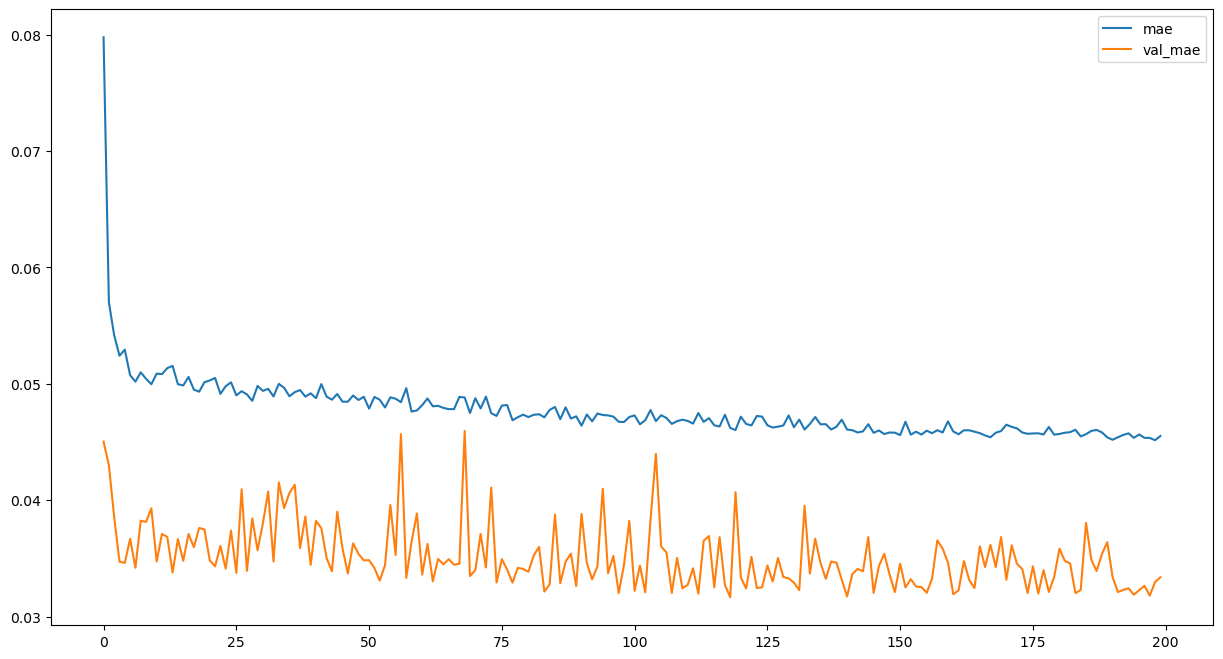

In [ ]:
pd.DataFrame(result.history)[["mae","val_mae"]].plot(figsize=(15,8))

In [ ]:
mae = np.array(result.history["val_mae"][-1]).reshape(1, -1)

In [ ]:
mae_inverse = scaler.inverse_transform(mae)

In [ ]:
print("The inverse transformed MAE is: ", mae_inverse[0,0])

The inverse transformed MAE is:  13.290618725866079


In [ ]:
y_pred = model.predict(X_test)
y_pred = [x[0] for x in y_pred]

2024-07-09 19:30:19.547972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-09 19:30:19.548460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-09 19:30:19.549071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 2ms/step


In [ ]:
y_pred = [x[0] for x in scaler.inverse_transform(pd.DataFrame(y_pred))]

In [ ]:
y_test_real = [x[0] for x in scaler.inverse_transform(pd.DataFrame(y_test))]

In [ ]:
mean_absolute_error(y_test_real, y_pred)

13.290619708794106

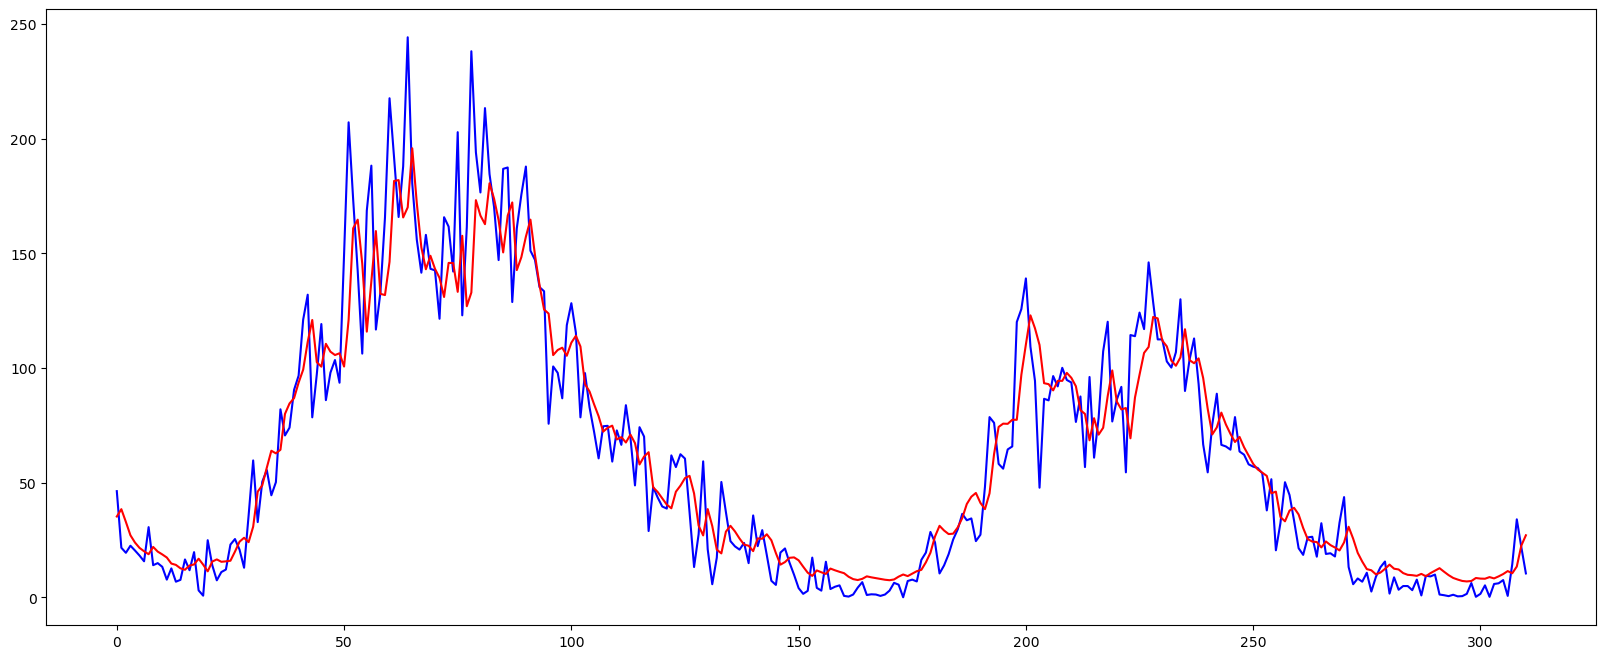

In [ ]:
plt.figure(figsize=(20, 8))  # Create a new figure with a specific size.
plt.plot(y_test_real, color='b')  # Plot the real values of the target variable.
plt.plot(y_pred, color='r')